In [4]:
!pip install matplotlib

In [27]:
!pip install sckit-image

ERROR: Could not find a version that satisfies the requirement sckit-image (from versions: none)
ERROR: No matching distribution found for sckit-image


In [2]:

import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torchvision import transforms, datasets
import cv2

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)



Using Pytorch version :  1.10.0  Device :  cuda


### 1. 데이터  탐색
https://github.com/RadicalHealthTech/CV-Assignment/blob/master/DL_task.ipynb

참조

In [3]:
import os


good_path = "./data/DRIMDB/Good/"
good_list= os.listdir(good_path)
#이미지만 캐기
good_data_list = [  data for data in  good_list if data != 'drimdb_good']

good_data = []
for data in good_data_list:
    temp_img=cv2.imread(good_path+data)
    #이미지 사이즈 논문에 맞게 512 512
    temp_img=cv2.resize(temp_img,(512,512))
    temp_img=cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)#PLOT 출력위해
    good_data.append(temp_img)
print("good: ",len(good_data))

good:  125


In [4]:
bad_path = "./data/DRIMDB/Bad/"
bad_list = os.listdir(bad_path)
bad_data_list = [  data for data in  bad_list if data != 'drimdb_bad']

bad_data = []
for data in bad_data_list:
    temp_img=cv2.imread(bad_path+data)
    #이미지 사이즈 논문에 맞게 512 512
    temp_img=cv2.resize(temp_img,(512,512))
    temp_img=cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)#PLOT 출력위해
    bad_data.append(temp_img)
print("bad: ",len(bad_data))


bad:  69


### good 이미지

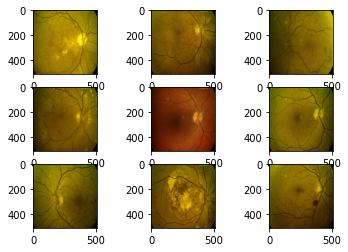

In [5]:
plt.figure(3)
for i in range(0,9):
    plt.subplot(3,3,i+1)
    plt.imshow(good_data[i])

### bad 이미지

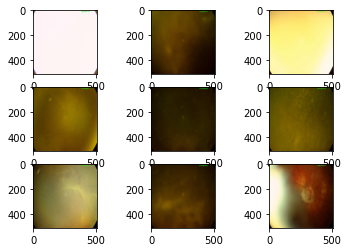

In [6]:
plt.figure(3)
for i in range(0,9):
    plt.subplot(3,3,i+1)
    plt.imshow(bad_data[i])

#### 캐니 에지 디텍션

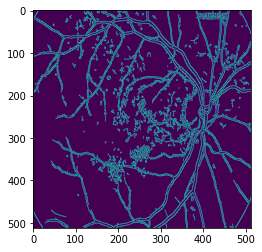

In [7]:
plt.imshow(cv2.Canny(good_data[0],50,100))

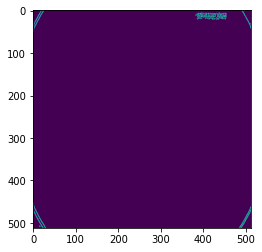

In [8]:
plt.imshow(cv2.Canny(bad_data[0],50,100))

## 2. 데이터 나누기 

In [22]:
#1. train, test 나누기
import os
import random #데이터 shuffle 사용
from glob import glob

GOOD_DATA_PATH_LIST = glob('./data/DRIMDB/Good/*.jpg')
BAD_DATA_PATH_LIST = glob('./data/DRIMDB/BAD/*.jpg')
print("GOOD : ",len(DATA_PATH_LIST))
print("BAD: ",len(BAD_DATA_PATH_LIST))

X = GOOD_DATA_PATH_LIST+BAD_DATA_PATH_LIST
print(len(X))
Y = {}
for idx,x in enumerate(X):
    if idx<125:
        Y[x]="Good"
    else:
        Y[x]="Bad"

#train 124  : valid 31 : test 39
random.shuffle(X)
DATA_PATH_TRAINING_LIST = X[:124]
DATA_PATH_VALIDATION_LIST = X[124:155]
DATA_PATH_TEST_LIST = X[155:194]

print(DATA_PATH_TEST_LIST)

GOOD :  194
BAD:  69
194
['./data/DRIMDB/Good\\drimdb_good (125).jpg', './data/DRIMDB/Good\\drimdb_good (45).jpg', './data/DRIMDB/Good\\drimdb_good (101).jpg', './data/DRIMDB/BAD\\drimdb_bad (27).jpg', './data/DRIMDB/Good\\drimdb_good (22).jpg', './data/DRIMDB/BAD\\drimdb_bad (43).jpg', './data/DRIMDB/Good\\drimdb_good (97).jpg', './data/DRIMDB/Good\\drimdb_good (9).jpg', './data/DRIMDB/BAD\\drimdb_bad (12).jpg', './data/DRIMDB/Good\\drimdb_good (105).jpg', './data/DRIMDB/Good\\drimdb_good (61).jpg', './data/DRIMDB/Good\\drimdb_good (5).jpg', './data/DRIMDB/BAD\\drimdb_bad (59).jpg', './data/DRIMDB/Good\\drimdb_good (42).jpg', './data/DRIMDB/Good\\drimdb_good (96).jpg', './data/DRIMDB/Good\\drimdb_good (91).jpg', './data/DRIMDB/Good\\drimdb_good (15).jpg', './data/DRIMDB/Good\\drimdb_good (6).jpg', './data/DRIMDB/Good\\drimdb_good (86).jpg', './data/DRIMDB/Good\\drimdb_good (112).jpg', './data/DRIMDB/Good\\drimdb_good (35).jpg', './data/DRIMDB/Good\\drimdb_good (73).jpg', './data/DRIMD

In [87]:

#2. 데이터 정의

from torch.utils.data import Dataset, DataLoader

classes = ["Good","Bad"]

class drimdb_dataset(Dataset):
    def __init__(self,data_path_list,classes):
        #클래스에서 사용할 인자를 받아 인스턴스 변수로 저장하는 일을 한다.
        #예를들면, 이미지의 경로 리스트를 저장하는 일을 하게 된다.
        self.path_list = data_path_list
        self.label = drimdb_dataset.get_label(data_path_list)
        self.classes=classes
    
    @classmethod
    def get_label(cls,data_path_list):
        label_list=[]
        for path in data_path_list:
            label_list.append(Y[path])
        #print(label_list)
        return label_list
    
    def __len__(self):
        return len(self.path_list)
        #데이터 셋의 길이를 정수로 반환한다. 
        
    def __getitem__(self, idx):
        """
        학습에 사용할 이미지를 반환하면 된다. 이 함수는 인풋으로 index를 받는다. 
        path_list에서 index에 해당하는 이미지를 읽으면 된다. 
        이때 텐서형태의 인풋이 들어오기때문에 리스트로 변환하여준다.(굳이 안해도됨)
        반환값으로는 경로로부터 읽어들여 transform을 적용한 이미지 파일과 정답에 해당하는 클래스를 반환하면 된다.
        이때, 클래스를 숫자로 반환하여야 한다. 
        예를들면 Good: 0 Bad:1. 클래스 리스트의 index로 반환하게 구현하였다.
        """
        image = cv2.resize(cv2.imread(self.path_list[idx]),(512,512))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image, self.classes.index(self.label[idx])





In [64]:
#3. 하이퍼 파라미터
BATCH_SIZE =  39 #한 배치당 39개 이미지
EPOCHS = 50 # 전체 데이터 셋을 50번 반복

In [88]:

#DATA LOADER 함수가 BATCH_size 단위로 분리해 지정.
train_loader = torch.utils.data.DataLoader(dataset = 
                                           drimdb_dataset(
                                               DATA_PATH_TRAINING_LIST,
                                               classes,
                                           ),
                                           batch_size = BATCH_SIZE,
                                           shuffle = True) # 순서가 암기되는것을 막기위해.


test_loader = torch.utils.data.DataLoader(dataset = 
                                           drimdb_dataset(
                                               DATA_PATH_TEST_LIST,
                                               classes,
                                           ),
                                           batch_size = BATCH_SIZE,
                                           shuffle = False) # 순서가 암기되는것을 막기위해.

#validation set 추가해야됨.
#https://bekusib.tistory.com/159
#이전 예제에서는 test를 중간 중간 실시했는데, 그러면 안됨.

X_train :  torch.Size([39, 512, 512, 3]) type: torch.ByteTensor
Y_train :  torch.Size([39]) type: torch.LongTensor


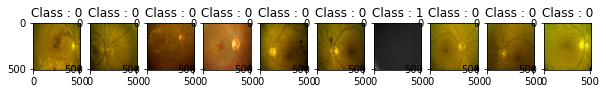

In [93]:
# 4. 데이터 확인하기
for (X_train,Y_train) in train_loader:
    print("X_train : ",X_train.size(),'type:',X_train.type())
    print("Y_train : ",Y_train.size(),'type:',Y_train.type())
    break

#배치 데이터한개
#X: 이미지. 32배치 사이즈. 3 rgb. 32x32 이미지.
#Y: 32개의 라벨

#print(np.transpose(X_train[i],(1,2,0)).shape)

# 이미지 데이터확인
#np.transpose로 (채널,세로,가로) -> (세로,가로,채널) 이렇게 해야지 그릴 수 있다.
pltsize = 1
plt.figure(figsize=(10*pltsize,pltsize))#하나당 10,1

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(X_train[i])# 배치에서 10개만 추출
    plt.title('Class : '+str(Y_train[i].item()))


## 3. 모델 설계